# Mauna Loa C02 Dataset

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_openml
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
from jax.lib import xla_bridge

In [4]:
from steinRF import GP, LowRankGP, MixGP
from steinRF.gp.kernels import RFF
from steinRF.gp.transforms import Transform, ARD
from steinRF.stein.targets import TFTarget

from steinRF.stein.srfr import srfr
# from steinRF.mar_srfr import mar_srfr
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae
from steinRF.gp.models import *
from steinRF.gp.gp import LinearMean

In [5]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [6]:
key = jax.random.PRNGKey(2024)

In [7]:
co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
c02_X = jnp.array((co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1))
c02_y = jnp.array(co2_data["co2"].to_numpy())

X_scaler = MinMaxScaler()
y_scaler = StandardScaler()
X = jnp.array(X_scaler.fit_transform(c02_X))
y = jnp.array(y_scaler.fit_transform(c02_y.reshape(-1, 1)).reshape(-1))


/tmp/ipykernel_127651/95892431.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=False)
X_train, X_val, y_train, y_val = jnp.array(X_train), jnp.array(X_val), jnp.array(y_train), jnp.array(y_val)
d = X_train.shape[1]

## Optimize Hyperparameters

In [10]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 5000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params, shuffle=False)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params, shuffle=False)
    return cross_val_acc



In [11]:
n_trials = 30
R = 50
q = 10
hparams = {}
mean = LinearMean(jnp.array([3.1]))

#### Basic RFF GP

In [49]:
# rff = build_train_rff(key, X_train, y_train, R=R, diag=1e-2, epochs=2000, lr=0.1, from_data=False)[0]
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False, init_ls=False, mean=mean
)
hparams["rff"] = rff_study.best_params

[I 2024-02-10 15:43:49,189] A new study created in memory with name: no-name-e3d34598-4c71-47af-be39-9eebff45b810


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-10 15:43:58,581] Trial 0 finished with value: 0.3455343930400586 and parameters: {'diag': 0.00023728487749439853, 'lr': 0.014673404693690438}. Best is trial 0 with value: 0.3455343930400586.
[I 2024-02-10 15:44:07,847] Trial 1 finished with value: 0.015993174909325742 and parameters: {'diag': 0.009684798129109806, 'lr': 0.02990172136810833}. Best is trial 1 with value: 0.015993174909325742.
[I 2024-02-10 15:44:16,909] Trial 2 finished with value: 0.017590959265045947 and parameters: {'diag': 0.07906848827508071, 'lr': 0.24510604629919666}. Best is trial 1 with value: 0.015993174909325742.
[I 2024-02-10 15:44:25,773] Trial 3 finished with value: 0.02226581207905402 and parameters: {'diag': 0.001327804222152309, 'lr': 0.0025632560365220075}. Best is trial 1 with value: 0.015993174909325742.
[I 2024-02-10 15:44:34,621] Trial 4 finished with value: 0.029430634009258473 and parameters: {'diag': 0.0006244793747376575, 'lr': 0.005873634693338499}. Best is trial 1 with value: 0.0159

#### Mixture SRFR

In [ ]:
# mix_rff = build_train_mix_rff(key, X_train, y_train, diag=1e-2, q=5, R=100, alpha=1.4, lr=0.1, from_data=False, epochs=1000)[0]
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=75, R=R, epochs=1000, from_data=False, mean=mean, q=8,
    gd_params=lambda t: [t.kernel.transform.scale], init_ls=False
)

## Train Models

In [24]:
params = {
    "rff": {'epochs': 1000, 'init_ls': False, 'from_data': False, 'mean': mean, 'diag': 0.011551596652291834, 'lr': 0.20439107033118334},
    "mix": {
        'diag': 0.0041190674069503195, 'lr': 0.00613498527363013, 'lr_gd': 0.11141388995274447, 'alpha': 2.2, 's': 0.5, 'q': 8,
        'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': False, 'from_data': False, 'mean': mean, 'epochs': 1000,
        'kernel': 'mmd'
    },
}

In [25]:
rff = build_train_rff(key, X_train, y_train, R=50, **params['rff'])[0]
mix_rff = build_train_mix_rff(key, X_train, y_train, R=50, **params['mix'])[0]

## Plot

In [26]:
sns.set_style("ticks")
sns.set_context("paper", rc={
    # 'font.size': 11,
    # "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
})

plt.rcParams.update({
    'font.size': 15,
    "axes.titlesize":15,
    "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
    # 'text.latex.preamble': r'\usepackage{amsfonts}; \usepackage{times}'
})

In [27]:
ws = mix_rff.kernel.kernel.w.reshape(8, 50)
Xd = jnp.linspace(0, 1, 100).reshape(-1, 1)
X0 = jnp.zeros((1, 1))

k_rff = rff.kernel(X0, Xd).reshape(-1)
phi_mix = mix_rff.kernel.phi(Xd)
phi_mix_0 = mix_rff.kernel.phi(X0)
kD_mix = jax.vmap(lambda p1, p2: p1 @ p2.T)(phi_mix_0, phi_mix).reshape(-1, 100)
kD_mix_mu = kD_mix.mean(axis=0)
kD_mix_sd = kD_mix.std(axis=0)

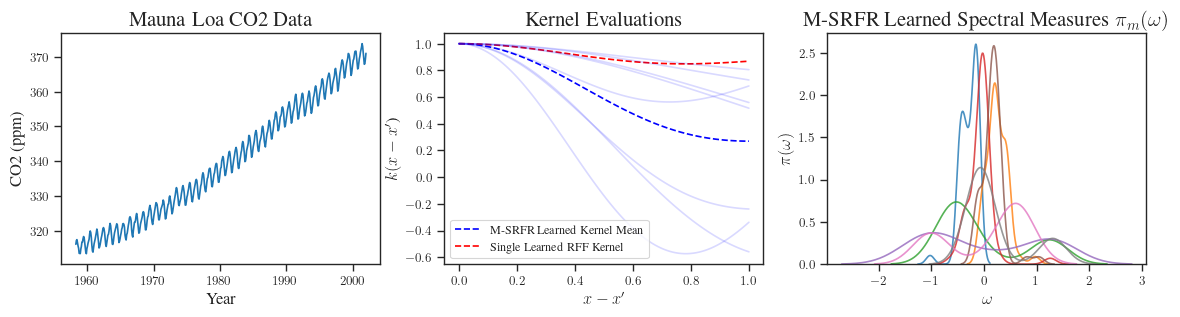

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

# plt 1
sns.lineplot(x=c02_X.flatten(), y=c02_y.flatten(), ax=ax[0])
ax[0].set_title("Mauna Loa CO2 Data")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("CO2 (ppm)")

# plt 2
sns.lineplot(x=Xd[:, 0], y=kD_mix_mu, color="blue", label="M-SRFR Learned Kernel Mean", linestyle="--", ax=ax[1])
# plt.fill_between(x=Xd[:, 0], y1=kD_mix_mu - kD_mix_sd, y2=kD_mix_mu + kD_mix_sd, color="blue", alpha=0.1)
sns.lineplot(x=Xd[:, 0], y=k_rff, color="red", linestyle="--", label="Single Learned RFF Kernel", ax=ax[1])

for i in range(8):
    sns.lineplot(x=Xd[:, 0], y=kD_mix[i], color="blue", alpha=0.15, ax=ax[1])

ax[1].legend()
ax[1].set_title("Kernel Evaluations")
ax[1].set_xlabel("$x - x^\prime$")
ax[1].set_ylabel("$k(x - x^\prime$)")

# plt 3
for i in range(8):
    sns.kdeplot(ws[i], alpha=0.8, ax=ax[2])

ax[2].set_title("M-SRFR Learned Spectral Measures $\pi_m(\omega)$")
ax[2].set_xlabel("$\omega$")
ax[2].set_ylabel("$\pi(\omega)$")
fig.savefig("../figures/co2.pdf", format="pdf", bbox_inches="tight", dpi=300)